In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 32.6 MB/s 


In [2]:
import logging
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [3]:
def data_generate():
  rand = torch.randn(100)
  x = rand
  y = rand * 4 + 2.
  return x, y
x, y=data_generate()

Text(0, 0.5, 'y')

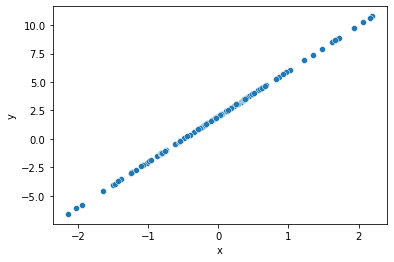

In [4]:
sns.scatterplot(x=x, y=y)
plt.xlabel('x') 
plt.ylabel('y')

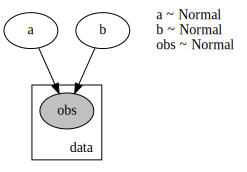

In [5]:
def model(x, y=None):
  a = pyro.sample("a", dist.Normal(0., 10.))
  b = pyro.sample("b", dist.Normal(0., 10.))

  mean = a * x + b

  with pyro.plate("data", len(x)):
    return pyro.sample("obs", dist.Normal(mean, 1), obs=y)

pyro.render_model(model, model_args=(x, y), render_distributions=True)

Elbo loss: 945.9286704063416
Elbo loss: 533.5513716936111
Elbo loss: 320.3973755836487
Elbo loss: 193.75009441375732
Elbo loss: 137.95364356040955
Elbo loss: 107.55754137039185
Elbo loss: 101.19967234134674
Elbo loss: 101.15415740013123
Elbo loss: 101.02119743824005
Elbo loss: 101.10083508491516


Text(0, 0.5, 'ELBO loss')

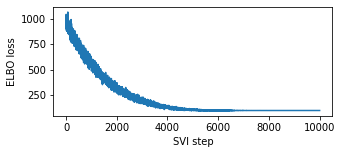

In [6]:
pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.001})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(10000):
    loss = svi.step(x, y)
    losses.append(loss)
    if step % 1000 == 0:
      print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

In [7]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 4.0061994
AutoNormal.scales.a 0.107507385
AutoNormal.locs.b 1.9872476
AutoNormal.scales.b 0.09731518


In [8]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=50)
svi_samples = predictive(x, y=None)
svi_gdp = svi_samples["obs"]

Text(0, 0.5, 'y')

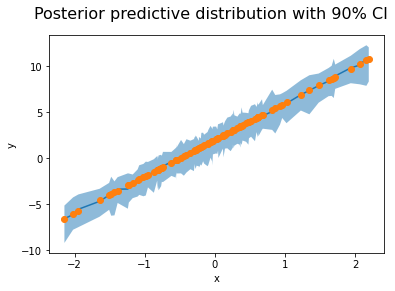

In [9]:
predictions = pd.DataFrame({
    "x": x,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "y": y,
})

pre = predictions.sort_values(by=["y"])

plt.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
plt.plot(pre["x"], pre["y_mean"])
plt.fill_between(pre["x"], pre["y_perc_5"], pre["y_perc_95"], alpha=0.5)
plt.plot(pre["x"], pre["y"], "o")

plt.xlabel('x') 
plt.ylabel('y')